# TFX on TF2 Vertex Pipelines
Author - Hasan Rafiq, Google

This notebook is a stepwise guide to build and deploy a TFX pipeline on TFX on TF2 and deploy on GCP and Local.

### Execution modes:
- TFX Pipeline - Interactive mode
- Test on Local mode
- Deploy on GCP

### Library versions:
- TFX 1.5.0
- TF 2.7.0

## Build Pipeline - Interactive mode

In [77]:
import os
import pprint
import numpy as np
import tempfile
import urllib

import absl
import pandas as pd
import tensorflow as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

import tfx
from google.protobuf.json_format import MessageToDict
from tfx.components import CsvExampleGen
from tfx.components.common_nodes.importer_node import ImporterNode
from typing import Dict, List, Text
from tfx.components import Evaluator, ExampleValidator, Pusher, SchemaGen, StatisticsGen, Transform, Tuner, Trainer
from tfx.dsl.components.base import executor_spec
from tfx.components.trainer.executor import GenericExecutor
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata, pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import pusher_pb2, trainer_pb2, tuner_pb2
from tfx.types import Channel
from tfx.types.standard_artifacts import Model, ModelBlessing, HyperParameters
from tfx.types import Channel
# from tfx.utils.dsl_utils import external_input

from tfx.extensions.google_cloud_ai_platform.trainer import component as gcp_trainer
from tfx.extensions.google_cloud_ai_platform.tuner import component as gcp_tuner
from tfx.extensions.google_cloud_ai_platform.pusher import component as gcp_pusher
from tfx.extensions.google_cloud_ai_platform.constants import ENABLE_VERTEX_KEY
from tfx.extensions.google_cloud_ai_platform.constants import VERTEX_REGION_KEY

from tensorflow_cloud import CloudTuner

%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

The tfx.orchestration.experimental.interactive.notebook_extensions.skip extension is already loaded. To reload it, use:
  %reload_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip


In [78]:
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.7.0
TFX version: 1.5.0


In [79]:
# Create TFX required directories
!rm -rf data.*
!rm -rf *trainer.py
!sudo rm -rf tfx/*

! mkdir tfx
! mkdir tfx/pipelines
! mkdir tfx/metadata
! mkdir tfx/logs
! mkdir tfx/data
! mkdir tfx/serving_model

mkdir: cannot create directory ‘tfx’: File exists


In [80]:
!wget https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv

--2022-01-15 07:55:27--  https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1922812 (1.8M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.83M  --.-KB/s    in 0.03s   

2022-01-15 07:55:28 (59.8 MB/s) - ‘data.csv’ saved [1922812/1922812]



In [84]:
df = pd.read_csv('data.csv')
df.to_csv("tfx/data/data_trans.csv", index=False, header=True)

In [86]:
%%bash
#Copy data data on GCS
PROJECT_ID="hasanrafiq-test-331814" 
BUCKET_NAME="gs://gcs-${PROJECT_ID}"

gsutil cp tfx/data/data_trans.csv ${BUCKET_NAME}/tfx/taxi/data/

Copying file://tfx/data/data_trans.csv [Content-Type=text/csv]...
/ [1 files][  1.9 MiB/  1.9 MiB]                                                
Operation completed over 1 objects/1.9 MiB.                                      


In [87]:
##Define all constant
_tfx_root = os.path.join(os.getcwd(), 'tfx');        # Create location ~/tfx
_pipeline_root = os.path.join(_tfx_root, 'pipelines');      # Join ~/tfx/pipelines/
_metadata_db_root = os.path.join(_tfx_root, 'metadata.db');    # Join ~/tfx/metadata.db
_log_root = os.path.join(_tfx_root, 'logs');
_model_root = os.path.join(_tfx_root, 'model');
_data_root = os.path.join(_tfx_root, 'data');
_serving_model_dir = os.path.join(_tfx_root, 'serving_model')
_data_filepath = os.path.join(_data_root, "data_trans.csv")

_transform_module_file = 'transform_trainer.py'
_model_trainer_module_file = 'model.py'

### First run in Interactive context

In [88]:
# Here, we create an InteractiveContext using default parameters. This will
# use a temporary directory with an ephemeral ML Metadata database instance.
# To use your own pipeline root or database, the optional properties
# `pipeline_root` and `metadata_connection_config` may be passed to
# InteractiveContext. Calls to InteractiveContext are no-ops outside of the
# notebook.
context = InteractiveContext(pipeline_root=_tfx_root)

In [89]:
example_gen = CsvExampleGen(input_base=_data_root)
context.run(example_gen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 1
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 1
        type_id: 14
        uri: "/home/jupyter/tfx/CsvExampleGen/examples/1"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "file_format"
          value {
            string_value: "tfrecords_gzip"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:2,total_bytes:4066648,xor_checksum:1002,sum_checksum:3284466700"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            int_value: 0
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        base_type: DATASET
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [90]:
### START CODE HERE
# Instantiate StatisticsGen with the ExampleGen ingested dataset
statistics_gen = StatisticsGen(examples=example_gen.outputs['examples'])
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 2
        type_id: 16
        uri: "/home/jupyter/tfx/StatisticsGen/statistics/2"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 16
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        base_type: STATISTICS
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [91]:
# Plot the statistics generated
context.show(statistics_gen.outputs['statistics'])

In [93]:
### START CODE HERE
# Instantiate SchemaGen with the output statistics from the StatisticsGen
schema_gen = SchemaGen(statistics=statistics_gen.outputs['statistics'])
    
# Run the component
context.run(schema_gen)
### END CODE HERE

ExecutionResult(
    component_id: SchemaGen
    execution_id: 4
    outputs:
        schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 3
        type_id: 18
        uri: "/home/jupyter/tfx/SchemaGen/schema/3"
        custom_properties {
          key: "name"
          value {
            string_value: "schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "SchemaGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        create_time_since_epoch: 1642233487421
        last_update_time_since_epoch: 1642233487439
        , artifact_type: id: 18
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [95]:
# Visualize the output
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'company',STRING,required,,'company'
'payment_type',STRING,required,,'payment_type'
'dropoff_census_tract',FLOAT,required,,-
'dropoff_community_area',FLOAT,required,,-
'dropoff_latitude',FLOAT,required,,-
'dropoff_longitude',FLOAT,required,,-
'fare',FLOAT,required,,-
'pickup_census_tract',FLOAT,required,,-
'pickup_community_area',FLOAT,required,,-


,Values
Domain,
'company',"'0118 - 42111 Godfrey S.Awir', '0694 - 59280 Chinesco Trans Inc', '1085 - 72312 N and W Cab Co', '2092 - 61288 Sbeih company', '2192 - 73487 Zeymane Corp', '2192 - Zeymane Corp', '2733 - 74600 Benny Jona', '3011 - 66308 JBL Cab Inc.', '3094 - 24059 G.L.B. Cab Co', '3152 - 97284 Crystal Abernathy', '3201 - C&D Cab Co Inc', '3253 - 91138 Gaither Cab Co.', '3319 - CD Cab Co', '3385 - Eman Cab', '3623 - 72222 Arrington Enterprises', '3897 - 57856 Ilie Malec', '3897 - Ilie Malec', '4053 - 40193 Adwar H. Nikola', '4197 - 41842 Royal Star', '4197 - Royal Star', '4615 - 83503 Tyrone Henderson', '4615 - Tyrone Henderson', '4623 - Jay Kim', '5006 - 39261 Salifu Bawa', '5006 - Salifu Bawa', '5074 - 54002 Ahzmi Inc', '5129 - 87128', '5129 - 98755 Mengisti Taxi', '585 - Valley Cab Co', '5864 - Thomas Owusu', '5874 - 73628 Sergey Cab Corp.', '5874 - Sergey Cab Corp.', '5997 - 65283 AW Services Inc.', '5997 - AW Services Inc.', '6057 - 24657 Richard Addo', '6488 - 83287 Zuha Taxi', '6743 - Luhak Corp', 'Blue Ribbon Taxi Association Inc.', 'C & D Cab Co Inc', 'Chicago Elite Cab Corp.', 'Chicago Elite Cab Corp. (Chicago Carriag', 'Chicago Medallion Leasing INC', 'Chicago Medallion Management', 'Choice Taxi Association', 'Dispatch Taxi Affiliation', 'KOAM Taxi Association', 'Northwest Management LLC', 'Taxi Affiliation Services', 'Top Cab Affiliation', '2809 - 95474 C & D Cab Co Inc.', '2823 - 73307 Seung Lee', '3201 - CID Cab Co Inc', '3385 - 23210 Eman Cab', '4053 - Adwar H. Nikola', '5074 - Ahzmi Inc', '5129 - Mengisti Taxi', '5724 - KYVI Cab Inc', '585 - 88805 Valley Cab Co', '5864 - 73614 Thomas Owusu', '6574 - Babylon Express Inc.', '6742 - 83735 Tasha ride inc'"
'payment_type',"'Cash', 'Credit Card', 'Dispute', 'No Charge', 'Pcard', 'Prcard', 'Unknown'"


In [96]:
### START CODE HERE
# Instantiate ExampleValidator with the statistics and schema from the previous steps
example_validator = ExampleValidator(statistics=statistics_gen.outputs['statistics'],
                              schema=schema_gen.outputs['schema'])
    
# Run the component
context.run(example_validator)
### END CODE HERE

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 5
    outputs:
        anomalies: Channel(
            type_name: ExampleAnomalies
            artifacts: [Artifact(artifact: id: 4
        type_id: 20
        uri: "/home/jupyter/tfx/ExampleValidator/anomalies/5"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "anomalies"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "ExampleValidator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 20
        name: "ExampleAnomalies"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [97]:
# Visualize the output
context.show(example_validator.outputs['anomalies'])

#### Transform component

In [98]:
%%writefile {_transform_module_file}

# Features to be scaled to the z-score
_DENSE_FLOAT_FEATURE_KEYS = [
]

# Features to bucketize
_BUCKET_FEATURE_KEYS = ['dropoff_latitude', 'dropoff_longitude', 'pickup_latitude', 'pickup_longitude']

_FEATURE_BUCKET_COUNT = {
    'dropoff_latitude': 30,
    'dropoff_longitude': 30,
    'pickup_latitude': 30, 
    'pickup_longitude': 30
}

# Number of vocabulary terms used for encoding VOCAB_FEATURES by tf.transform
_VOCAB_SIZE = 1000

# Count of out-of-vocab buckets in which unrecognized VOCAB_FEATURES are hashed.
_OOV_SIZE = 10

# Features with string data types that will be converted to indices
_VOCAB_FEATURE_KEYS = [
    'payment_type', 
    'company',
    'trip_start_day', 
    'trip_start_hour',
    'trip_start_month'
]

# Features with int data type that will be kept as is
_CATEGORICAL_FEATURE_KEYS = [
]

# Feature to predict
_FARE_KEY = 'fare'

def _transformed_name(key):
    return key

Writing transform_trainer.py


In [99]:
%%writefile -a {_transform_module_file}

import tensorflow as tf
import tensorflow_transform as tft

def preprocessing_fn(inputs):
    """tf.transform's callback function for preprocessing inputs.
    Args:
        inputs: map from feature keys to raw not-yet-transformed features.
    Returns:
        Map from string feature key to transformed feature operations.
    """
    outputs = {}
    
    # Required as TF2 has issues with TFT, mentioned in documentation - 
    # https://tensorflow.google.cn/tfx/transform/tf2_support#retaining_the_legacy_tftransform_behavior
    
    ### START CODE HERE
    # Scale these features to the z-score.
    for key in _DENSE_FLOAT_FEATURE_KEYS:
        # Scale these features to the z-score.
        outputs[_transformed_name(key)] = tft.scale_to_z_score(_fill_in_missing(inputs[key]))

    # Scale these feature/s from 0 to 1
    # for key in _RANGE_FEATURE_KEYS:
    #     outputs[_transformed_name(key)] = tft.scale_to_0_1(inputs[key])

    # Transform the strings into indices 
    # hint: use the VOCAB_SIZE and OOV_SIZE to define the top_k and num_oov parameters
    for key in _VOCAB_FEATURE_KEYS:
        outputs[_transformed_name(key)] = tft.compute_and_apply_vocabulary(_fill_in_missing(inputs[key]), 
                                                                           top_k=_VOCAB_SIZE, 
                                                                           num_oov_buckets=_OOV_SIZE,
                                                                           vocab_filename=key)

    # Bucketize the feature
    for key in _BUCKET_FEATURE_KEYS:
        outputs[_transformed_name(key)] = tft.bucketize(_fill_in_missing(inputs[key]), num_buckets=_FEATURE_BUCKET_COUNT[key])

    # Keep inputs as is. No tft function needed.
    for key in _CATEGORICAL_FEATURE_KEYS:
        outputs[_transformed_name(key)] = _fill_in_missing(inputs[key])

    # Use `tf.cast` to cast the label key to float32 and fill in the missing values.
    outputs[_transformed_name(_FARE_KEY)] = _fill_in_missing(inputs[_FARE_KEY])

    #Feat Engg: New features
    outputs['distance'] = tf.pow(tf.cast((outputs['pickup_latitude'] - outputs['dropoff_latitude'])**2 + (outputs['pickup_longitude'] - outputs['dropoff_longitude'])**2, tf.float32), 0.5)

    ### END CODE HERE
    return outputs


def _fill_in_missing(x):
    """Replace missing values in a SparseTensor.
    Fills in missing values of `x` with '' or 0, and converts to a dense tensor.
    Args:
    x: A `SparseTensor` of rank 2.  Its dense shape should have size at most 1
      in the second dimension.
    Returns:
    A rank 1 tensor where missing values of `x` have been filled in.
    """
    
    if not isinstance(x, tf.sparse.SparseTensor):
        return x

    default_value = '' if x.dtype == tf.string else 0
    return tf.squeeze(
      tf.sparse.to_dense(
          tf.SparseTensor(x.indices, x.values, [x.dense_shape[0], 1]),
          default_value),
      axis=1)

Appending to transform_trainer.py


In [100]:
### START CODE HERE
# Instantiate the Transform component
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    force_tf_compat_v1=True,  ##Disable TF2 behavior as currently there are issues when we run on DataFlowRunner
    module_file=os.path.abspath(_transform_module_file))
    
# Run the component.
# The `enable_cache` flag is disabled in case you need to update your transform module file.
context.run(transform, enable_cache=False)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying transform_trainer.py -> build/lib
copying model.py -> build/lib
installing to /tmp/tmpaddk9qg9
running install
running install_lib
copying build/lib/model.py -> /tmp/tmpaddk9qg9
copying build/lib/transform_trainer.py -> /tmp/tmpaddk9qg9
running install_egg_info
running egg_info
creating tfx_user_code_Transform.egg-info
writing tfx_user_code_Transform.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Transform.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Transform.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
Copying tfx_user_code_Transform.egg-info to /tmp/tmpaddk9qg9/tfx_user_code_Transform-0.0+8e09f327d686440e665985b2fa11c290a43efacb7c3d66178442d0b777e54bf6-py3.7.egg-info
runn

/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


Processing ./tfx/_wheels/tfx_user_code_Transform-0.0+8e09f327d686440e665985b2fa11c290a43efacb7c3d66178442d0b777e54bf6-py3-none-any.whl
Processing ./tfx/_wheels/tfx_user_code_Transform-0.0+8e09f327d686440e665985b2fa11c290a43efacb7c3d66178442d0b777e54bf6-py3-none-any.whl
Processing ./tfx/_wheels/tfx_user_code_Transform-0.0+8e09f327d686440e665985b2fa11c290a43efacb7c3d66178442d0b777e54bf6-py3-none-any.whl


INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'Counter' object has no attribute 'name'
INFO:tensorflow:SavedModel written to: /home/jupyter/tfx/Transform/transform_graph/6/.temp_path/tftransform_tmp/75f8f13c1b034d7e9c1ca3524f8158b7/saved_model.pb
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'Counter' object has no attribute 'name'
INFO:tensorflow:SavedModel written to: /home/jupyter/tfx/Transform/transform_graph/6/.temp_path/tftransform_tmp/6706a26f31384924850c40cff7a9f7e0/saved_model.pb


INFO:tensorflow:tensorflow_text is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:tensorflow_text is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:Assets written to: /home/jupyter/tfx/Transform/transform_graph/6/.temp_path/tftransform_tmp/462b72ae29bc4577af444edd897b5c2a/assets
INFO:tensorflow:SavedModel written to: /home/jupyter/tfx/Transform/transform_graph/6/.temp_path/tftransform_tmp/462b72ae29bc4577af444edd897b5c2a/saved_model.pb
INFO:tensorflow:tensorflow_text is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:struct2tensor is not availa

ExecutionResult(
    component_id: Transform
    execution_id: 6
    outputs:
        transform_graph: Channel(
            type_name: TransformGraph
            artifacts: [Artifact(artifact: id: 5
        type_id: 22
        uri: "/home/jupyter/tfx/Transform/transform_graph/6"
        custom_properties {
          key: "name"
          value {
            string_value: "transform_graph"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 22
        name: "TransformGraph"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        transformed_examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 6
        type_id: 14
        uri: "/home/jupyter/tfx/Transform/transformed_examples/6"
        properties {
          key: "split_names"
          value {
            string_value: "[\"eval\", \"train\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "transformed_examples"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        base_type: DATASET
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        updated_analyzer_cache: Channel(
            type_name: TransformCache
            artifacts: [Artifact(artifact: id: 7
        type_id: 23
        uri: "/home/jupyter/tfx/Transform/updated_analyzer_cache/6"
        custom_properties {
          key: "name"
          value {
            string_value: "updated_analyzer_cache"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 23
        name: "TransformCache"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        pre_transform_schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 8
        type_id: 18
        uri: "/home/jupyter/tfx/Transform/pre_transform_schema/6"
        custom_properties {
          key: "name"
          value {
            string_value: "pre_transform_schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0

In [101]:
##Examine the transformed data
def get_records(dataset, num_records):
    '''Extracts records from the given dataset.
    Args:
        dataset (TFRecordDataset): dataset saved by ExampleGen
        num_records (int): number of records to preview
    '''
    
    # initialize an empty list
    records = []

    ### START CODE HERE
    # Use the `take()` method to specify how many records to get
    for tfrecord in dataset.take(num_records):
        
        # Get the numpy property of the tensor
        serialized_example = tfrecord.numpy()
        
        # Initialize a `tf.train.Example()` to read the serialized data
        example = tf.train.Example()
        
        # Read the example data (output is a protocol buffer message)
        example.ParseFromString(serialized_example)
        
        # convert the protocol bufffer message to a Python dictionary
        example_dict = MessageToDict(example)
        
        # append to the records list
        records.append(example_dict)
        
    ### END CODE HERE
    return records

try:
    # Get the URI of the output artifact representing the transformed examples
    train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'Split-train')
    
except IndexError:
    print("context.run() was no-op")
    train_uri = os.path.join(transform_graph_uri, 'train')
    
# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
transformed_dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
# Get 3 records from the dataset
sample_records_xf = get_records(transformed_dataset, 3)

# Print the output
pp.pprint(sample_records_xf)

[{'features': {'feature': {'company': {'int64List': {'value': ['10']}},
                           'distance': {'floatList': {'value': [0.0]}},
                           'dropoff_latitude': {'int64List': {'value': ['0']}},
                           'dropoff_longitude': {'int64List': {'value': ['29']}},
                           'fare': {'floatList': {'value': [0.0]}},
                           'payment_type': {'int64List': {'value': ['3']}},
                           'pickup_latitude': {'int64List': {'value': ['0']}},
                           'pickup_longitude': {'int64List': {'value': ['29']}},
                           'trip_start_day': {'int64List': {'value': ['2']}},
                           'trip_start_hour': {'int64List': {'value': ['2']}},
                           'trip_start_month': {'int64List': {'value': ['7']}}}}},
 {'features': {'feature': {'company': {'int64List': {'value': ['0']}},
                           'distance': {'floatList': {'value': [20.0]}},
      

#### Trainer component

In [102]:
%%writefile {_model_trainer_module_file}

"""WideDeep Classifier."""
import functools
import absl
import os
from typing import List, Text

import kerastuner
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_transform as tft

from tfx.components.trainer.executor import TrainerFnArgs
from tfx.components.trainer.fn_args_utils import DataAccessor
from tfx.components.tuner.component import TunerFnResult
from tfx_bsl.tfxio import dataset_options
from tensorflow_cloud import CloudTuner

LABEL_KEY = 'fare'
TRAIN_BATCH_SIZE = 128
EVAL_BATCH_SIZE = 512
BUCKET_SIZE = 30

# Define feature columns(Including feature engineered ones )
# These are the features which come from the TF Data pipeline
def create_feature_cols():
    #Keras format features
    k_month = tf.keras.Input(name='trip_start_month', shape=(1,), dtype=tf.int32, sparse=False)
    k_hour  = tf.keras.Input(name='trip_start_hour', shape=(1,), dtype=tf.int32, sparse=False)
    k_day  = tf.keras.Input(name='trip_start_day', shape=(1,), dtype=tf.int32, sparse=False)
    k_payment_type  = tf.keras.Input(name='payment_type', shape=(1,), dtype=tf.int32, sparse=False)
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32, sparse=False)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32, sparse=False)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32, sparse=False)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32, sparse=False)
    k_distance  = tf.keras.Input(name='distance', shape=(1,), dtype=tf.float32, sparse=False)
    keras_dict_input = {'trip_start_month': k_month, 'trip_start_hour': k_hour, 'trip_start_day' : k_day,
                        'pickup_latitude': k_picklat, 'pickup_longitude': k_picklon,
                        'dropoff_latitude': k_droplat, 'dropoff_longitude': k_droplon, 'distance' : k_distance,
                        'payment_type' : k_payment_type
                        }

    return({'K' : keras_dict_input})

def _gzip_reader_fn(filenames):
  """Small utility returning a record reader that can read gzip'ed files."""
  return tf.data.TFRecordDataset(filenames, compression_type='GZIP')

def get_serving_signature(_mod, tfo):
    _mod.tft_layer_inference = tfo.transform_features_layer()
    _mod.raw_feature_spec = tfo.raw_feature_spec()

    @tf.function
    def serving(trip_start_day, trip_start_hour, trip_start_month,
                                        dropoff_latitude,
                                        dropoff_longitude,
                                        pickup_latitude,
                                        pickup_longitude,
                                        payment_type):
        #Params coming in request
        features = {
            'dropoff_latitude': dropoff_latitude,
            'dropoff_longitude': dropoff_longitude,
            'pickup_latitude': pickup_latitude,
            'pickup_longitude': pickup_longitude,
            'trip_start_day': trip_start_day,
            'trip_start_hour': trip_start_hour,
            'trip_start_month': trip_start_month,
            'payment_type': payment_type,
        }

        #Generate raw feature spec
        raw_feature_spec = _mod.raw_feature_spec
        # print(raw_feature_spec)
        
        #Add TFT transformations
        raw_features = {}
        for key, val in features.items():
            if key not in raw_feature_spec:
                continue
            if isinstance(raw_feature_spec[key], tf.io.VarLenFeature):
                raw_features[key] = tf.RaggedTensor.from_tensor(tf.expand_dims(val, -1)).to_sparse()
                continue
            raw_features[key] = val
            
            ##Apply INT32 to INT64 conversion because TFT accepts INT64 and we have taken all INTs as INT32
            if raw_feature_spec[key].dtype == tf.int64:
                raw_features[key] = tf.cast(raw_features[key], tf.int64)
        
        #Get all features from TFT
        tft_features = _mod.tft_layer_inference(raw_features)

        ## Predict
        ##IF THERE IS AN ERROR IN NUMBER OF PARAMS PASSED HERE OR DATA TYPE THEN IT GIVES ERROR, "COULDN'T COMPUTE OUTPUT TENSOR"
        predictions = _mod(tft_features)
        return predictions
    
    return serving

# TFX Tuner will call this function.
def tuner_fn(fn_args: TrainerFnArgs) -> TunerFnResult:
  """Build the tuner using the KerasTuner API.
  Args:
    fn_args: Holds args as name/value pairs.
      - working_dir: working dir for tuning.
      - train_files: List of file paths containing training tf.Example data.
      - eval_files: List of file paths containing eval tf.Example data.
      - train_steps: number of train steps.
      - eval_steps: number of eval steps.
      - schema_path: optional schema of the input data.
      - transform_graph_path: optional transform graph produced by TFT.
  Returns:
    A namedtuple contains the following:
      - tuner: A BaseTuner that will be used for tuning.
      - fit_kwargs: Args to pass to tuner's run_trial function for fitting the
                    model , e.g., the training and validation dataset. Required
                    args depend on the above tuner's implementation.
  """
  transform_graph = tft.TFTransformOutput(fn_args.transform_graph_path)
  
  # Construct a build_keras_model_fn that just takes hyperparams from get_hyperparameters as input.
  build_keras_model_fn = functools.partial(
      create_keras_model, tf_transform_output=transform_graph)  

  # BayesianOptimization is a subclass of kerastuner.Tuner which inherits from BaseTuner.    
  tuner = kerastuner.Hyperband(
      build_keras_model_fn,
      max_epochs=10,
      hyperparameters=_get_hyperparameters(),
      # New entries allowed for n_units hyperparameter construction conditional on n_layers selected.
#       allow_new_entries=True,
#       tune_new_entries=True,
      objective=kerastuner.Objective('val_rmse', 'min'),
      directory=fn_args.working_dir,
      project_name='taxi_tuning')
  
#   tuner = CloudTuner(
#       build_keras_model_fn,
#       # max_epochs=10,
#       hyperparameters=_get_hyperparameters(),
#       # New entries allowed for n_units hyperparameter construction conditional on n_layers selected.
# #       allow_new_entries=True,
# #       tune_new_entries=True,
#       objective=kerastuner.Objective('val_rmse', 'min'),
#       directory=fn_args.working_dir,
#       project_name='taxi_tuning',
#       project_id='hasanrafiq-test-331814',
#       region='us-central1'
#     )  
    
  train_dataset = _input_fn(
      fn_args.train_files,
      fn_args.data_accessor,
      transform_graph,
      batch_size=TRAIN_BATCH_SIZE)

  eval_dataset = _input_fn(
      fn_args.eval_files,
      fn_args.data_accessor,
      transform_graph,
      batch_size=EVAL_BATCH_SIZE)

  return TunerFnResult(
      tuner=tuner,
      fit_kwargs={
          'x': train_dataset,
          'validation_data': eval_dataset,
          'steps_per_epoch': fn_args.train_steps,
          'validation_steps': fn_args.eval_steps
      })

def _input_fn(file_pattern: List[Text],
              data_accessor: DataAccessor,
              tf_transform_output: tft.TFTransformOutput,
              batch_size: int = 200) -> tf.data.Dataset:
  """Generates features and label for tuning/training.
  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    tf_transform_output: A TFTransformOutput.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch
  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """
  dataset = data_accessor.tf_dataset_factory(
      file_pattern,
      dataset_options.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=LABEL_KEY),
      tf_transform_output.transformed_metadata.schema)
    
  return dataset


def _get_hyperparameters() -> kerastuner.HyperParameters:
  """Returns hyperparameters for building Keras model."""
  hp = kerastuner.HyperParameters()
  # Defines search space.
  hp.Float('learning_rate', 0.0001, 0.01, default=0.001)
  hp.Int('hidden_layers', 1, 1, step=1, default=1)
  # with hp.conditional_scope('hidden_layers', 1):
  #       hp.Int('n_units_1', min_value=8, max_value=128, step=8, default=8)
  # with hp.conditional_scope('n_layers', 2):
  #       hp.Int('n_units_1', min_value=8, max_value=128, step=8, default=8)
  #       hp.Int('n_units_2', min_value=8, max_value=128, step=8, default=8)        

  return hp

def create_keras_model(hparams: kerastuner.HyperParameters,
                       tf_transform_output: tft.TFTransformOutput):

    feature_cols = create_feature_cols()
    cat_fields = {}

    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])

    ##Input processing
    ##https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
    ##https://github.com/tensorflow/community/blob/master/rfcs/20191212-keras-categorical-inputs.md

    ##Handle categorical attributes( One-hot encoding by taking input as integer )
    for field in ['trip_start_day', 'trip_start_hour', 'trip_start_month', 'payment_type']:
        cat_fields[field] = tf.keras.layers.CategoryEncoding(num_tokens=tf_transform_output.vocabulary_size_by_name(vocab_filename=field) + 1)(feature_cols['K'][field])

    ##Handle Bucket attributes( One-hot encoding by taking input as integer )
    for field in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
        cat_fields[field] = tf.keras.layers.CategoryEncoding(num_tokens=BUCKET_SIZE + 1)(feature_cols['K'][field])

    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    feature_cols['K']['distance'], 
                    # embed_cross_pick_lon_lat, embed_cross_drop_lon_lat,
                    tf.cast(feature_cols['K']['trip_start_day'], tf.float32), 
                    tf.cast(feature_cols['K']['trip_start_hour'], tf.float32), 
                    tf.cast(feature_cols['K']['trip_start_month'], tf.float32)
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.BatchNormalization()(x_input_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_categ = tf.keras.layers.concatenate(
                    [cat_fields[f_] for f_ in cat_fields.keys()]
    )
    
    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(int(hparams.get('hidden_layers'))):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.00001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr = hparams.get('learning_rate'))

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

# TFX Trainer will call this function.
def run_fn(fn_args: TrainerFnArgs):
  """Train the model based on given args.
  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """
  tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)

  train_dataset = _input_fn(
      fn_args.train_files, 
      fn_args.data_accessor, 
      tf_transform_output, 
      TRAIN_BATCH_SIZE)

  eval_dataset = _input_fn(
      fn_args.eval_files, 
      fn_args.data_accessor,
      tf_transform_output, 
      EVAL_BATCH_SIZE)

  if fn_args.hyperparameters:
    hparams = kerastuner.HyperParameters.from_config(fn_args.hyperparameters)
  else:
    # This is a shown case when hyperparameters is decided and Tuner is removed
    # from the pipeline. User can also inline the hyperparameters directly in
    # _build_keras_model.
    hparams = _get_hyperparameters()
  absl.logging.info('HyperParameters for training: %s' % hparams.get_config())

  # Distribute training over multiple replicas on the same machine.
  mirrored_strategy = tf.distribute.MirroredStrategy()
  with mirrored_strategy.scope():
    model = create_keras_model(
        hparams=hparams,
        tf_transform_output=tf_transform_output
        )

    #Add callbacks
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.001, verbose = 1)

    model.fit(
      train_dataset,
      epochs=fn_args.custom_config['epochs'],
      steps_per_epoch=fn_args.train_steps,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps,
      callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True), 
                   reduce_lr]
      # callbacks=[tensorboard_callback]
      )

    #get signatures for serving_default -> Used for prediction via REST API
    serving = get_serving_signature(model, tf_transform_output). \
                                    get_concrete_function(trip_start_day=tf.TensorSpec([None,1], dtype= tf.int32, name='trip_start_day'), 
                                        trip_start_hour=tf.TensorSpec([None,1], dtype= tf.int32, name='trip_start_hour'),
                                        trip_start_month=tf.TensorSpec([None,1], dtype= tf.int32, name='trip_start_month'), 
                                        dropoff_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_latitude'),
                                        dropoff_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_longitude'), 
                                        pickup_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_latitude'),
                                        pickup_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_longitude'),
                                        payment_type=tf.TensorSpec([None,1], dtype= tf.string, name='payment_type'))

    model.save(fn_args.serving_model_dir, save_format='tf', signatures=serving)
        
  # model.save(fn_args.serving_model_dir + "/1", save_format='tf', signatures=sig)
  print("Model saved on: " + fn_args.serving_model_dir)

Overwriting model.py


#### Non-HPT train

In [103]:
trainer = Trainer(
    module_file=os.path.abspath(_model_trainer_module_file),
    custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
    examples=transform.outputs['transformed_examples'],
    train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100), ##goes as train_steps / steps_per_epoch
    eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=3), ##goes as eval_steps
    transform_graph=transform.outputs['transform_graph'],
    custom_config=({"epochs": 2})
    )

context.run(trainer)

/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying transform_trainer.py -> build/lib
copying model.py -> build/lib
installing to /tmp/tmpg8wz9ybk
running install
running install_lib
copying build/lib/model.py -> /tmp/tmpg8wz9ybk
copying build/lib/transform_trainer.py -> /tmp/tmpg8wz9ybk
running install_egg_info
running egg_info
creating tfx_user_code_Trainer.egg-info
writing tfx_user_code_Trainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Trainer.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Trainer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
Copying tfx_user_code_Trainer.egg-info to /tmp/tmpg8wz9ybk/tfx_user_code_Trainer-0.0+8e09f327d686440e665985b2fa11c290a43efacb7c3d66178442d0b777e54bf6-py3.7.egg-info
running install_script

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-01-15 07:59:36.528409: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['company'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 trip_start_day (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 trip_start_hour (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 trip_start_month (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 payment_type (InputLayer)      [(None, 1)]          0           []                               
                                                                                            

ExecutionResult(
    component_id: Trainer
    execution_id: 7
    outputs:
        model: Channel(
            type_name: Model
            artifacts: [Artifact(artifact: id: 13
        type_id: 25
        uri: "/home/jupyter/tfx/Trainer/model/7"
        custom_properties {
          key: "name"
          value {
            string_value: "model"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Trainer"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 25
        name: "Model"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        model_run: Channel(
            type_name: ModelRun
            artifacts: [Artifact(artifact: id: 14
        type_id: 26
        uri: "/home/jupyter/tfx/Trainer/model_run/7"
        custom_properties {
          key: "name"
          value {
            string_value: "model_run"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Trainer"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 26
        name: "ModelRun"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

#### Local TMS prediction

Check Exported graph's signature

In [ ]:
!saved_model_cli show --dir "tfx/Trainer/model/6/Format-Serving/" --all

In [ ]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.keras.models.load_model("tfx/Trainer/model/6/Format-Serving/")

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(dropoff_latitude=tf.convert_to_tensor([40.920452]), dropoff_longitude = tf.convert_to_tensor([-87.679955]), pickup_latitude = tf.convert_to_tensor([41.952823]), 
  pickup_longitude =tf.convert_to_tensor([-87.653244]), trip_start_day=tf.convert_to_tensor([[1]]), trip_start_hour=tf.convert_to_tensor([[5]]),
  trip_start_month=tf.convert_to_tensor([[6]]), payment_type=tf.convert_to_tensor([["Cash"]]))

#### HPT Training

Uncomment and run below cells if HPT is required to be run
- First HPT is run
- Then re-training is done with the best hyperparams from HPT

In [ ]:
##First run hyperparam tuning
# tuner = Tuner(
#     module_file=os.path.abspath(_model_trainer_module_file),
#     # custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
#     examples=transform.outputs['transformed_examples'],
#     train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100), ##goes as train_steps / steps_per_epoch
#     eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=3), ##goes as eval_steps
#     transform_graph=transform.outputs['transform_graph'],
#     custom_config=({"epochs": 10})
#     )

# context.run(tuner)

In [ ]:
# hparams_importer = ImporterNode(
#     # instance_name='import_hparams',
#     # This can be Tuner's output file or manually edited file. The file contains
#     # text format of hyperparameters (kerastuner.HyperParameters.get_config())
#     source_uri=tuner.outputs['best_hyperparameters'].get()[0].uri,
#     artifact_type=HyperParameters)

# context.run(hparams_importer)

In [ ]:
##Retrain with best hyper parameters
# trainer = Trainer(
#     custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
#     module_file=_model_trainer_module_file,
#     transformed_examples=transform.outputs['transformed_examples'],
#     # schema=schema_importer.outputs.result,
#     transform_graph=transform.outputs['transform_graph'],
#     hyperparameters=hparams_importer.outputs['result'],
#     custom_config=({"epochs": 20}),
#     train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100),
#     eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=3))

# context.run(trainer)

### Pusher

In [ ]:
pusher = Pusher(
    model=trainer.outputs['model'],
    # model_blessing=evaluator.outputs['blessing'],
    push_destination = ({'filesystem': {
            'base_directory': "tfx/Trainer/model/9/Format-Serving/"
        }}))

context.run(pusher)

ExecutionResult(
    component_id: Pusher
    execution_id: 8
    outputs:
        pushed_model: Channel(
            type_name: PushedModel
            artifacts: [Artifact(artifact: id: 17
        type_id: 28
        uri: "/home/jupyter/tfx/Pusher/pushed_model/8"
        custom_properties {
          key: "name"
          value {
            string_value: "pushed_model"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Pusher"
          }
        }
        custom_properties {
          key: "pushed"
          value {
            int_value: 1
          }
        }
        custom_properties {
          key: "pushed_destination"
          value {
            string_value: "tfx/Trainer/model/9/Format-Serving/1642177192"
          }
        }
        custom_properties {
          key: "pushed_version"
          value {
            string_value: "1642177192"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.5.0"
          }
        }
        state: LIVE
        , artifact_type: id: 28
        name: "PushedModel"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

### Run TFX pipeline in Local

Test the whole pipeline in DirectRunnerMode in local environment, using local compute resources

**Restart** kernel before executing next steps

In [107]:
import os
import pprint
import numpy as np
import tempfile
import urllib

import absl
import pandas as pd
import tensorflow as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

import tfx
from google.protobuf.json_format import MessageToDict
from tfx.components import CsvExampleGen
from tfx.components.common_nodes.importer_node import ImporterNode
from typing import Dict, List, Text
from tfx.components import Evaluator, ExampleValidator, Pusher, SchemaGen, StatisticsGen, Transform, Tuner, Trainer
from tfx.components.base import executor_spec
from tfx.components.trainer.executor import GenericExecutor
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata, pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import pusher_pb2, trainer_pb2, tuner_pb2
from tfx.types import Channel
from tfx.types.standard_artifacts import Model, ModelBlessing, HyperParameters
from tfx.types import Channel
# from tfx.utils.dsl_utils import external_input

from tfx.extensions.google_cloud_ai_platform.trainer import component as gcp_trainer
from tfx.extensions.google_cloud_ai_platform.tuner import component as gcp_tuner
from tfx.extensions.google_cloud_ai_platform.pusher import component as gcp_pusher
from tfx.extensions.google_cloud_ai_platform.constants import ENABLE_VERTEX_KEY
from tfx.extensions.google_cloud_ai_platform.constants import VERTEX_REGION_KEY

from tensorflow_cloud import CloudTuner

%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

_transform_module_file = 'transform_trainer.py'
_model_trainer_module_file = 'model.py'

The tfx.orchestration.experimental.interactive.notebook_extensions.skip extension is already loaded. To reload it, use:
  %reload_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip


In [108]:
# https://github.com/tensorflow/tfx/blob/master/tfx/examples/chicago_taxi_pipeline/
def create_final_pipeline(
    pipeline_name: Text,
    root_path: Text,
    data_path: Text,
    training_params: Dict[Text, Text],
    transform_module: Text,
    model_module: Text,
    project_id = "",
    region = "",
    use_vertex_ai = False,
    beam_pipeline_args = ['--direct_num_workers=%d' % 0],
) -> pipeline.Pipeline:

    _pipeline_root = os.path.join(root_path, 'pipelines');      # Join ~/tfx/pipelines/
    _metadata_db_root = os.path.join(root_path, 'metadata.db');    # Join ~/tfx/metadata.db
    _log_root = os.path.join(root_path, 'logs');
    _model_root = os.path.join(root_path, 'model');
    _serving_model_dir = os.path.join(root_path, 'serving_model')

    # Full pipeline
    example_gen = CsvExampleGen(input_base=data_path)

    statistics_gen = StatisticsGen(examples=example_gen.outputs['examples'])

    schema_gen = SchemaGen(
      statistics=statistics_gen.outputs['statistics'])

    validate_stats = ExampleValidator(
        statistics=statistics_gen.outputs['statistics'],
        schema=schema_gen.outputs['schema'])

    transform = Transform(
        examples=example_gen.outputs['examples'],
        schema=schema_gen.outputs['schema'],
        force_tf_compat_v1=True,
        module_file=transform_module)

    ##Don't use Vertex AI services
    if use_vertex_ai == False:
        tuner = Tuner(
                module_file=model_module,
                # custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
                examples=transform.outputs['transformed_examples'],
                train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100), ##goes as train_steps / steps_per_epoch
                eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=3), ##goes as eval_steps
                transform_graph=transform.outputs['transform_graph'],
                custom_config=({"epochs": 10}))
        
        trainer = Trainer(
                    custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
                    module_file=model_module,
                    transformed_examples=transform.outputs['transformed_examples'],
                    # schema=schema_importer.outputs.result,
                    transform_graph=transform.outputs['transform_graph'],
                    hyperparameters=tuner.outputs['best_hyperparameters'],
                    custom_config=training_params,
                    train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100),
                    eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=3))
        
        pusher = Pusher(
                    model=trainer.outputs['model'],
                    push_destination = ({'filesystem': {
                            'base_directory': _serving_model_dir }}))
    else:
    ##Use Vertex AI services
    
        ##Tuner
        vertex_tuner_job_spec = {
              'project': project_id,
              'region': region
              # 'job_spec': {
              #     'worker_pool_specs': [{
              #         'machine_spec': {
              #             'machine_type': 'n1-standard-4',
              #         },
              #         'replica_count': 1,
              #         'container_spec': {
              #             'image_uri': 'gcr.io/tfx-oss-public/tfx:{}'.format(tfx.__version__),
              #         },
              #     }]
              # },
          }
        
        tuner = gcp_tuner.Tuner(
                      module_file=model_module,
                      examples=transform.outputs['transformed_examples'],
                      tune_args=tuner_pb2.TuneArgs(num_parallel_trials=1),
                      train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100),
                      eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=3),
                      transform_graph=transform.outputs['transform_graph'],
                      custom_config={
                          ENABLE_VERTEX_KEY:
                              True,
                          VERTEX_REGION_KEY:
                              region,
                          tfx.extensions.google_cloud_ai_platform.tuner.executor.TUNING_ARGS_KEY:
                              vertex_tuner_job_spec,
                          "epochs": 10
                      })
        
        ##Trainer
        vertex_trainer_job_spec = {
              'project': project_id,
              'worker_pool_specs': [{
                  'machine_spec': {
                      'machine_type': 'n1-standard-4',
                  },
                  'replica_count': 1,
                  'container_spec': {
                      'image_uri': 'gcr.io/tfx-oss-public/tfx:{}'.format(tfx.__version__),
                  },
              }],
          }
        
        trainer = gcp_trainer.Trainer(
                      module_file=model_module,
                      transformed_examples=transform.outputs['transformed_examples'],
                      train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=100),
                      eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=3),
                      hyperparameters=tuner.outputs['best_hyperparameters'],
                      transform_graph=transform.outputs['transform_graph'],
                      custom_config={
                          ENABLE_VERTEX_KEY:
                              True,
                          VERTEX_REGION_KEY:
                              region,
                          tfx.extensions.google_cloud_ai_platform.trainer.executor.TRAINING_ARGS_KEY:
                              vertex_trainer_job_spec,
                          "epochs": training_params["epochs"]
                      })

        # NEW: Pushes the model to Vertex AI Endpoints
        # NEW: Configuration for pusher.
        vertex_serving_spec = {
          'project_id': project_id,
          'endpoint_name': 'tfx_taxi_ep',
          'machine_type': 'n1-standard-4',
        }
        
        serving_image = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-7:latest'
        pusher = gcp_pusher.Pusher(
              model=trainer.outputs['model'],
              custom_config={
                  ENABLE_VERTEX_KEY:
                      True,
                  VERTEX_REGION_KEY:
                      region,
                  tfx.extensions.google_cloud_ai_platform.constants.VERTEX_CONTAINER_IMAGE_URI_KEY:
                      serving_image,
                  tfx.extensions.google_cloud_ai_platform.constants.SERVING_ARGS_KEY:
                    vertex_serving_spec,
              })

    # This pipeline obj carries the business logic of the pipeline, but no runner-specific information
    # was included.    
    return pipeline.Pipeline(
        pipeline_name=  pipeline_name,
        pipeline_root=  root_path,
        components=[
            example_gen, 
            statistics_gen, schema_gen, validate_stats,
            transform, tuner, trainer, pusher
        ],
        metadata_connection_config = metadata.sqlite_metadata_connection_config(_metadata_db_root),
        enable_cache=False,
        beam_pipeline_args=beam_pipeline_args,
    )

In [ ]:
#First Run full pipeline locally
from tfx.orchestration.local.local_dag_runner import LocalDagRunner

##Define all paths
_tfx_root = os.path.join(os.getcwd(), 'tfx')

#Config params
training_params = {"epochs": 20}

#Create and run pipeline
p_ = create_final_pipeline(root_path = _tfx_root, 
                           pipeline_name="local_pipeline", 
                           data_path=os.path.join(os.getcwd(), "tfx/data"),
                           training_params=training_params,
                           transform_module=os.path.abspath(_transform_module_file),
                           model_module=os.path.abspath(_model_trainer_module_file)
                          )

## UNCOMMENT: To test Local pipeline( only for DEBUGGING )
LocalDagRunner().run(p_)

Trial 30 Complete [00h 00m 10s]
val_rmse: 4.5256667137146

Best val_rmse So Far: 4.454364776611328
Total elapsed time: 00h 03m 04s
INFO:tensorflow:Oracle triggered exit


Results summary
Results in /home/jupyter/tfx/Tuner/.system/executor_execution/6/.temp/6/taxi_tuning
Showing 10 best trials
Objective(name='val_rmse', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.008446007397109268
hidden_layers: 1
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 4.454364776611328
Trial summary
Hyperparameters:
learning_rate: 0.0037279646610859254
hidden_layers: 1
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 4.514078617095947
Trial summary
Hyperparameters:
learning_rate: 0.007352845848950337
hidden_layers: 1
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 4.5256667137146
Trial summary
Hyperparameters:
learning_rate: 0.008446007397109268
hidden_layers: 1
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 7f2271dd58f6c3132b02dcd619f5cbd2
Score: 4.550266742706299
Trial summary
Hyperparameters:
learning_rate: 0.00810780061467

2022-01-15 08:07:03.152157: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


100/100 [==============================] - 6s 25ms/step - loss: 152.6994 - rmse: 12.3572 - val_loss: 53.6905 - val_rmse: 7.3274 - lr: 0.0084
Epoch 2/20
100/100 [==============================] - 1s 12ms/step - loss: 34.7792 - rmse: 5.8974 - val_loss: 28.3530 - val_rmse: 5.3247 - lr: 0.0084
Epoch 3/20
100/100 [==============================] - 1s 13ms/step - loss: 101.2586 - rmse: 10.0627 - val_loss: 32.1474 - val_rmse: 5.6699 - lr: 0.0084
Epoch 4/20
100/100 [==============================] - 1s 10ms/step - loss: 28.2645 - rmse: 5.3164 - val_loss: 27.7868 - val_rmse: 5.2713 - lr: 0.0084
Epoch 5/20
100/100 [==============================] - 1s 13ms/step - loss: 96.1201 - rmse: 9.8041 - val_loss: 29.5523 - val_rmse: 5.4362 - lr: 0.0084
Epoch 6/20
100/100 [==============================] - 1s 10ms/step - loss: 88.2610 - rmse: 9.3947 - val_loss: 45.6534 - val_rmse: 6.7567 - lr: 0.0084
Epoch 7/20
100/100 [==============================] - 1s 10ms/step - loss: 56.7383 - rmse: 7.5325 - val_los

### Run TFX pipeline on GCP - Vertex pipelines

Run the whole TFX pipeline on Vertex Pipelines now, using GCP's native services
- Vertex Pipelines for orchestration
- DataFlow for creating TFRecord, computing Schema, computing Statistics
- AIP for HTP
- Vertex training for Model training
- Vertex Endpoints and Vertex Model for serving

In [76]:
%%bash
# move necessary files to GCS
PROJECT_ID="hasanrafiq-test-331814" 
BUCKET_NAME="gs://gcs-${PROJECT_ID}"

gsutil cp transform_trainer.py ${BUCKET_NAME}/tfx/taxi/code/
gsutil cp model.py ${BUCKET_NAME}/tfx/taxi/code/

Copying file://transform_trainer.py [Content-Type=text/x-python]...
/ [1 files][  3.8 KiB/  3.8 KiB]                                                
Operation completed over 1 objects/3.8 KiB.                                      
Copying file://model.py [Content-Type=text/x-python]...
/ [1 files][ 14.6 KiB/ 14.6 KiB]                                                
Operation completed over 1 objects/14.6 KiB.                                     


In [61]:
import os
from tfx.orchestration.kubeflow.v2 import kubeflow_v2_dag_runner

PIPELINE_NAME = 'tfx-taxi-customml'
PIPELINE_DEFINITION_FILE = PIPELINE_NAME + '-pipeline.json'
GOOGLE_CLOUD_REGION = 'us-central1'

PROJECT_ID = "hasanrafiq-test-331814" 
BUCKET_NAME = "gs://gcs-" + PROJECT_ID
PIPELINE_ROOT = f"{BUCKET_NAME}/"

TRANSFORM_MODULE = f"{BUCKET_NAME}/tfx/taxi/code/transform_trainer.py"
MODEL_MODULE = f"{BUCKET_NAME}/tfx/taxi/code/model.py"

training_params = {"epochs": 20}
use_cloud_services = True  ##If training on vertex with GCP services

##Define all paths
_tfx_root = os.path.join(PIPELINE_ROOT, 'tfx')

##Pickup runner as per value of "use_cloud_services"
runners = {True : 'DataflowRunner', False : 'DirectRunner'}

##Dataflow configuration
beam_pipeline_args = [
    f'--runner={runners[use_cloud_services]}',
    f'--project={PROJECT_ID}',
    f'--temp_location={BUCKET_NAME}/tmp',
    f'--region={GOOGLE_CLOUD_REGION}',
    f'--staging_location={BUCKET_NAME}/staging'
]

##Set Vertex Runner
# KFP V2 Runner - Vertex
gcp_runner = kubeflow_v2_dag_runner.KubeflowV2DagRunner(
    config = kubeflow_v2_dag_runner.KubeflowV2DagRunnerConfig(),
    output_filename=PIPELINE_DEFINITION_FILE)

#KFP V1 Runner - AI Platform
# runner_config = kubeflow_dag_runner.KubeflowDagRunnerConfig(
#       kubeflow_metadata_config=kubeflow_dag_runner.get_default_kubeflow_metadata_config())
# gcp_runner = kubeflow_dag_runner.KubeflowDagRunner(config=runner_config)

p_ = create_final_pipeline(root_path = _tfx_root, 
                           pipeline_name=PIPELINE_NAME, 
                           data_path=os.path.join(_tfx_root, "taxi/data"),
                           training_params=training_params,
                           beam_pipeline_args=beam_pipeline_args,
                           transform_module=TRANSFORM_MODULE,
                           model_module=MODEL_MODULE,
                           project_id=PROJECT_ID,
                           region=GOOGLE_CLOUD_REGION,
                           use_vertex_ai=use_cloud_services
                          )

# Following function will write the pipeline definition to PIPELINE_DEFINITION_FILE.
_ = gcp_runner.run(p_)

In [62]:
# docs_infra: no_execute
from google.cloud import aiplatform
from google.cloud.aiplatform import pipeline_jobs

aiplatform.init(location=GOOGLE_CLOUD_REGION)

job = pipeline_jobs.PipelineJob(template_path=PIPELINE_DEFINITION_FILE,
                                display_name=PIPELINE_NAME,
                                pipeline_root=os.path.join(PIPELINE_ROOT, 'pipeline_root'))
job.run(sync=False)

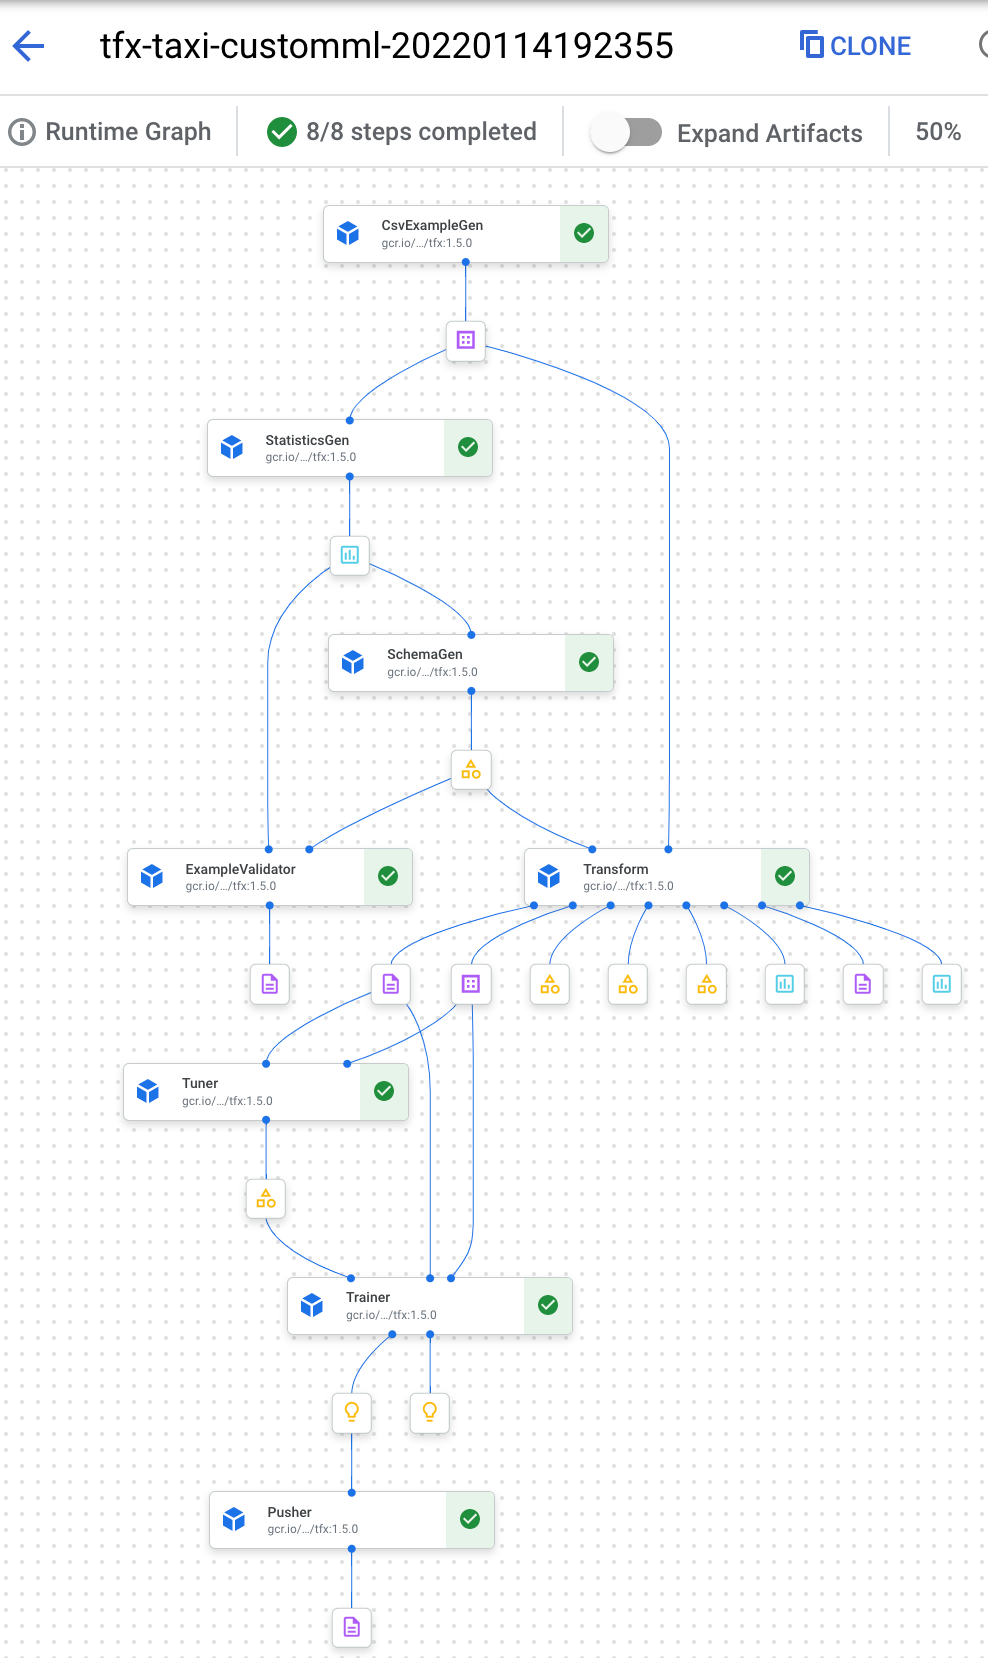

#### Test Vertex AI - Deployed Model

In [63]:
%%writefile payload.json

{
   "instances":[
      {
         "dropoff_latitude":41.920452,
         "dropoff_longitude":-87.679955,
         "pickup_latitude":41.952823,
         "pickup_longitude":-87.653244,
         "trip_start_day":[1],
         "trip_start_hour":[5],
         "trip_start_month":[6],
         "payment_type":["Cash"]
      }
   ]
}

Writing payload.json


In [67]:
%%bash
ENDPOINT_ID="3719770982068518912"
PROJECT_ID="hasanrafiq-test-331814"
INPUT_DATA_FILE="payload.json"

curl \
-X POST \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-H "Content-Type: application/json" \
https://us-central1-aiplatform.googleapis.com/v1/projects/${PROJECT_ID}/locations/us-central1/endpoints/${ENDPOINT_ID}:predict \
-d "@${INPUT_DATA_FILE}"

{
  "predictions": [
    [
      7.05827951
    ]
  ],
  "deployedModelId": "7133393946499088384",
  "model": "projects/318948681665/locations/us-central1/models/4000080476453732352",
  "modelDisplayName": "v1642193183"
}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   537    0   222  100   315    674    957 --:--:-- --:--:-- --:--:--  1627
